In [62]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.metrics import  precision_score, recall_score, f1_score,balanced_accuracy_score
import seaborn as sns
from tqdm import tqdm
from utils.Preprocessing_utils import output_selection_prepro
from utils.heatmap_plots import plot_heat_map, plot_metrics
from predict_model import test_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from models.FeedForwardNet.model import Net as Net
from models.FeedForwardNet.model_3 import Net as Net3
from torchvision import models

In [63]:
df = pd.read_csv('data/raw/dukecathr.csv')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [64]:

train_losses=[]
train_accu=[]
eval_losses=[]
eval_accu=[]
balance_accuracy_list = []
precision_list = []
recall_list = []

In [65]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for data in tqdm(dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        pred = model(inputs)
        predicted = torch.round(pred)  # Round the output probabilities to get binary predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    return train_loss, accu

In [66]:
def evaluate_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for data in dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        predicted = torch.round(outputs)  # Round the output probabilities to get binary predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Store all labels and predictions for metric calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.detach().cpu().numpy())  # Detach the tensor before converting to numpy
            
    test_loss=running_loss/len(dataloader)
    test_accu=100.*correct/total

    # Calculate metrics
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    return test_loss, test_accu, balance_acc, precision, recall

In [67]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=25, model_path='models/FeedForwardNet/saved_model.pth'):
    model = model.to(device)  # Move the model to the GPU
    
    for epoch in range(num_epochs):
        print(f'Epoch : {epoch+1}')
        
        train_loss, accu = train_epoch(model, train_dataloader, criterion, optimizer)
        train_accu.append(accu)
        train_losses.append(train_loss)

        test_loss, test_accu, balance_acc, precision, recall = evaluate_epoch(model, test_dataloader, criterion)
        eval_losses.append(test_loss)
        eval_accu.append(test_accu)

        # Append the metrics to the lists
        balance_accuracy_list.append(balance_acc)
        precision_list.append(precision)
        recall_list.append(recall)

        print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {accu:.3f} | Test Loss: {test_loss:.3f} | Test Accuracy: {test_accu:.3f} | Balance Accuracy: {balance_acc:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f}')
        
    torch.save(model.state_dict(), model_path)

In [68]:
def evaluate_model(model, dataloader, criterion):
    model = model.to(device)  # Move the model to the GPU
    model.eval()  # Set model to evaluate mode
    running_loss=0
    correct=0
    total=0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data in tqdm(dataloader):
            images,labels=data[0].to(device),data[1].to(device)
            outputs=model(images)
            loss= criterion(outputs,labels)
            running_loss+=loss.item()
            predicted = torch.round(outputs)  # Round the output probabilities to get binary predictions
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Store all labels and predictions for metric calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
    test_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    eval_losses.append(test_loss)
    eval_accu.append(accu)
    
    # Calculate metrics
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    # Append the metrics to the lists
    balance_accuracy_list.append(balance_acc)
    precision_list.append(precision)
    recall_list.append(recall)

    print(f'Test Loss: {test_loss:.3f} | Accuracy: {accu:.3f}')

In [69]:
def process_target(df, target, model):
   # Step 1: Preprocess the data
   X, y, num_cols, cat_cols = output_selection_prepro(df, target)

   # Split the data into train and test sets
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=465)
   
   Scaler = StandardScaler( )
   X_train = Scaler.fit_transform(X_train)
   X_test = Scaler.transform(X_test)
   
   
   # Convert features and labels to tensors
   X_train_tensor = torch.tensor(X_train.astype(np.float32))
   X_test_tensor = torch.tensor(X_test.astype(np.float32))
   y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1)
   y_test_tensor = torch.tensor(y_test.values).float().unsqueeze(1)

   # Convert the data into PyTorch tensors and load them into a DataLoader
   train_data = TensorDataset(X_train_tensor, y_train_tensor)
   test_data = TensorDataset(X_test_tensor, y_test_tensor)
   #save test data
   torch.save(test_data, f'data/processed/{target}/test_data.pth')

   batch_size = 2048
   train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
   test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

   # Define the model, loss function, and optimizer
   model = model
   criterion = nn.BCELoss()
   optimizer = torch.optim.Adam(model.parameters(), lr=0.00009)

   # Train the model
   train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=150)

   evaluate_model(model, test_loader, criterion)

In [70]:
process_target(df, 'RCAST', Net3(43))

Loading data from data/processed/RCAST/imputed_data_RCAST.csv...


No missing values found.
Final X columns: ['RDAYSFROMINDEX', 'RSEQCATHNUM', 'RSUBJID', 'YRCATH_G', 'AGE_G', 'GENDER', 'RACE_G', 'DPCABG', 'DPMI', 'DPPCI', 'HXANGINA', 'HXCEREB', 'HXCHF', 'HXCOPD', 'HXDIAB', 'HXHTN', 'HXHYL', 'HXMI', 'HXSMOKE', 'NUMPRMI', 'DIASBP_R', 'PULSE_R', 'SYSBP_R', 'CBRUITS', 'HEIGHT_R', 'S3', 'WEIGHT_R', 'CREATININE_R', 'HDL_R', 'LDL_R', 'TOTCHOL_R', 'CATHAPPR', 'DIAGCATH', 'INTVCATH', 'CORDOM', 'GRAFTST', 'LVEF_R', 'DAYS2LKA', 'DSCABG', 'DSMI', 'DSPCI', 'DSSTROKE', 'FUPROTCL']
Epoch : 1


100%|██████████| 25/25 [00:00<00:00, 30.11it/s]


Train Loss: 0.678 | Train Accuracy: 57.178 | Test Loss: 0.657 | Test Accuracy: 67.021 | Balance Accuracy: 0.641 | Precision: 0.722 | Recall: 0.763
Epoch : 2


100%|██████████| 25/25 [00:00<00:00, 34.10it/s]


Train Loss: 0.625 | Train Accuracy: 65.405 | Test Loss: 0.598 | Test Accuracy: 69.797 | Balance Accuracy: 0.664 | Precision: 0.734 | Recall: 0.805
Epoch : 3


100%|██████████| 25/25 [00:00<00:00, 37.19it/s]


Train Loss: 0.590 | Train Accuracy: 68.806 | Test Loss: 0.571 | Test Accuracy: 71.015 | Balance Accuracy: 0.670 | Precision: 0.734 | Recall: 0.837
Epoch : 4


100%|██████████| 25/25 [00:00<00:00, 35.82it/s]


Train Loss: 0.571 | Train Accuracy: 70.181 | Test Loss: 0.558 | Test Accuracy: 71.875 | Balance Accuracy: 0.673 | Precision: 0.732 | Recall: 0.862
Epoch : 5


100%|██████████| 25/25 [00:00<00:00, 37.50it/s]


Train Loss: 0.559 | Train Accuracy: 71.009 | Test Loss: 0.548 | Test Accuracy: 72.478 | Balance Accuracy: 0.676 | Precision: 0.732 | Recall: 0.879
Epoch : 6


100%|██████████| 25/25 [00:00<00:00, 31.62it/s]


Train Loss: 0.552 | Train Accuracy: 71.447 | Test Loss: 0.536 | Test Accuracy: 72.764 | Balance Accuracy: 0.680 | Precision: 0.735 | Recall: 0.877
Epoch : 7


100%|██████████| 25/25 [00:00<00:00, 44.58it/s]


Train Loss: 0.546 | Train Accuracy: 71.642 | Test Loss: 0.533 | Test Accuracy: 72.979 | Balance Accuracy: 0.682 | Precision: 0.737 | Recall: 0.878
Epoch : 8


100%|██████████| 25/25 [00:00<00:00, 38.48it/s]


Train Loss: 0.542 | Train Accuracy: 71.902 | Test Loss: 0.532 | Test Accuracy: 73.182 | Balance Accuracy: 0.683 | Precision: 0.737 | Recall: 0.884
Epoch : 9


100%|██████████| 25/25 [00:00<00:00, 37.27it/s]


Train Loss: 0.538 | Train Accuracy: 72.261 | Test Loss: 0.528 | Test Accuracy: 73.254 | Balance Accuracy: 0.686 | Precision: 0.739 | Recall: 0.879
Epoch : 10


100%|██████████| 25/25 [00:00<00:00, 37.17it/s]


Train Loss: 0.535 | Train Accuracy: 72.332 | Test Loss: 0.526 | Test Accuracy: 73.367 | Balance Accuracy: 0.688 | Precision: 0.741 | Recall: 0.877
Epoch : 11


100%|██████████| 25/25 [00:00<00:00, 30.76it/s]


Train Loss: 0.534 | Train Accuracy: 72.561 | Test Loss: 0.525 | Test Accuracy: 73.439 | Balance Accuracy: 0.688 | Precision: 0.741 | Recall: 0.879
Epoch : 12


100%|██████████| 25/25 [00:00<00:00, 31.13it/s]


Train Loss: 0.531 | Train Accuracy: 72.663 | Test Loss: 0.521 | Test Accuracy: 73.481 | Balance Accuracy: 0.688 | Precision: 0.740 | Recall: 0.883
Epoch : 13


100%|██████████| 25/25 [00:00<00:00, 35.07it/s]


Train Loss: 0.528 | Train Accuracy: 72.812 | Test Loss: 0.521 | Test Accuracy: 73.594 | Balance Accuracy: 0.690 | Precision: 0.742 | Recall: 0.880
Epoch : 14


100%|██████████| 25/25 [00:00<00:00, 37.15it/s]


Train Loss: 0.526 | Train Accuracy: 73.037 | Test Loss: 0.517 | Test Accuracy: 73.893 | Balance Accuracy: 0.694 | Precision: 0.745 | Recall: 0.881
Epoch : 15


100%|██████████| 25/25 [00:00<00:00, 35.97it/s]


Train Loss: 0.524 | Train Accuracy: 73.172 | Test Loss: 0.513 | Test Accuracy: 73.982 | Balance Accuracy: 0.695 | Precision: 0.746 | Recall: 0.881
Epoch : 16


100%|██████████| 25/25 [00:00<00:00, 30.50it/s]


Train Loss: 0.522 | Train Accuracy: 73.162 | Test Loss: 0.517 | Test Accuracy: 74.096 | Balance Accuracy: 0.696 | Precision: 0.746 | Recall: 0.883
Epoch : 17


100%|██████████| 25/25 [00:00<00:00, 31.52it/s]


Train Loss: 0.521 | Train Accuracy: 73.491 | Test Loss: 0.513 | Test Accuracy: 74.173 | Balance Accuracy: 0.699 | Precision: 0.750 | Recall: 0.875
Epoch : 18


100%|██████████| 25/25 [00:00<00:00, 34.94it/s]


Train Loss: 0.518 | Train Accuracy: 73.612 | Test Loss: 0.513 | Test Accuracy: 74.149 | Balance Accuracy: 0.697 | Precision: 0.748 | Recall: 0.880
Epoch : 19


100%|██████████| 25/25 [00:00<00:00, 36.70it/s]


Train Loss: 0.518 | Train Accuracy: 73.461 | Test Loss: 0.510 | Test Accuracy: 74.239 | Balance Accuracy: 0.701 | Precision: 0.752 | Recall: 0.872
Epoch : 20


100%|██████████| 25/25 [00:00<00:00, 43.83it/s]


Train Loss: 0.517 | Train Accuracy: 73.572 | Test Loss: 0.506 | Test Accuracy: 74.400 | Balance Accuracy: 0.699 | Precision: 0.749 | Recall: 0.884
Epoch : 21


100%|██████████| 25/25 [00:00<00:00, 43.11it/s]


Train Loss: 0.515 | Train Accuracy: 73.809 | Test Loss: 0.506 | Test Accuracy: 74.531 | Balance Accuracy: 0.704 | Precision: 0.754 | Recall: 0.876
Epoch : 22


100%|██████████| 25/25 [00:00<00:00, 37.71it/s]


Train Loss: 0.515 | Train Accuracy: 73.785 | Test Loss: 0.503 | Test Accuracy: 74.603 | Balance Accuracy: 0.704 | Precision: 0.753 | Recall: 0.878
Epoch : 23


100%|██████████| 25/25 [00:00<00:00, 35.31it/s]


Train Loss: 0.514 | Train Accuracy: 73.721 | Test Loss: 0.504 | Test Accuracy: 74.639 | Balance Accuracy: 0.705 | Precision: 0.755 | Recall: 0.876
Epoch : 24


100%|██████████| 25/25 [00:00<00:00, 34.22it/s]


Train Loss: 0.511 | Train Accuracy: 74.068 | Test Loss: 0.502 | Test Accuracy: 74.788 | Balance Accuracy: 0.706 | Precision: 0.755 | Recall: 0.879
Epoch : 25


100%|██████████| 25/25 [00:00<00:00, 34.86it/s]


Train Loss: 0.510 | Train Accuracy: 74.040 | Test Loss: 0.502 | Test Accuracy: 74.872 | Balance Accuracy: 0.709 | Precision: 0.758 | Recall: 0.874
Epoch : 26


100%|██████████| 25/25 [00:00<00:00, 37.74it/s]


Train Loss: 0.511 | Train Accuracy: 74.197 | Test Loss: 0.501 | Test Accuracy: 74.907 | Balance Accuracy: 0.706 | Precision: 0.755 | Recall: 0.883
Epoch : 27


100%|██████████| 25/25 [00:00<00:00, 34.75it/s]


Train Loss: 0.510 | Train Accuracy: 74.064 | Test Loss: 0.504 | Test Accuracy: 74.890 | Balance Accuracy: 0.709 | Precision: 0.758 | Recall: 0.875
Epoch : 28


100%|██████████| 25/25 [00:00<00:00, 31.09it/s]


Train Loss: 0.509 | Train Accuracy: 74.171 | Test Loss: 0.499 | Test Accuracy: 74.961 | Balance Accuracy: 0.708 | Precision: 0.756 | Recall: 0.881
Epoch : 29


100%|██████████| 25/25 [00:00<00:00, 35.93it/s]


Train Loss: 0.507 | Train Accuracy: 74.418 | Test Loss: 0.501 | Test Accuracy: 75.027 | Balance Accuracy: 0.710 | Precision: 0.759 | Recall: 0.876
Epoch : 30


100%|██████████| 25/25 [00:00<00:00, 37.57it/s]


Train Loss: 0.507 | Train Accuracy: 74.424 | Test Loss: 0.501 | Test Accuracy: 75.057 | Balance Accuracy: 0.709 | Precision: 0.757 | Recall: 0.881
Epoch : 31


100%|██████████| 25/25 [00:00<00:00, 47.79it/s]


Train Loss: 0.506 | Train Accuracy: 74.322 | Test Loss: 0.499 | Test Accuracy: 75.140 | Balance Accuracy: 0.712 | Precision: 0.760 | Recall: 0.876
Epoch : 32


100%|██████████| 25/25 [00:00<00:00, 46.69it/s]


Train Loss: 0.505 | Train Accuracy: 74.615 | Test Loss: 0.495 | Test Accuracy: 75.146 | Balance Accuracy: 0.711 | Precision: 0.760 | Recall: 0.877
Epoch : 33


100%|██████████| 25/25 [00:00<00:00, 41.86it/s]


Train Loss: 0.503 | Train Accuracy: 74.559 | Test Loss: 0.498 | Test Accuracy: 75.158 | Balance Accuracy: 0.712 | Precision: 0.760 | Recall: 0.877
Epoch : 34


100%|██████████| 25/25 [00:00<00:00, 35.21it/s]


Train Loss: 0.502 | Train Accuracy: 74.720 | Test Loss: 0.497 | Test Accuracy: 75.164 | Balance Accuracy: 0.712 | Precision: 0.761 | Recall: 0.876
Epoch : 35


100%|██████████| 25/25 [00:00<00:00, 36.53it/s]


Train Loss: 0.501 | Train Accuracy: 74.629 | Test Loss: 0.494 | Test Accuracy: 75.337 | Balance Accuracy: 0.714 | Precision: 0.762 | Recall: 0.877
Epoch : 36


100%|██████████| 25/25 [00:00<00:00, 36.60it/s]


Train Loss: 0.501 | Train Accuracy: 74.854 | Test Loss: 0.499 | Test Accuracy: 75.319 | Balance Accuracy: 0.715 | Precision: 0.763 | Recall: 0.875
Epoch : 37


100%|██████████| 25/25 [00:00<00:00, 32.45it/s]


Train Loss: 0.500 | Train Accuracy: 74.901 | Test Loss: 0.498 | Test Accuracy: 75.355 | Balance Accuracy: 0.715 | Precision: 0.763 | Recall: 0.876
Epoch : 38


100%|██████████| 25/25 [00:00<00:00, 33.17it/s]


Train Loss: 0.500 | Train Accuracy: 74.710 | Test Loss: 0.495 | Test Accuracy: 75.367 | Balance Accuracy: 0.715 | Precision: 0.762 | Recall: 0.876
Epoch : 39


100%|██████████| 25/25 [00:00<00:00, 36.14it/s]


Train Loss: 0.499 | Train Accuracy: 74.687 | Test Loss: 0.494 | Test Accuracy: 75.284 | Balance Accuracy: 0.716 | Precision: 0.766 | Recall: 0.867
Epoch : 40


100%|██████████| 25/25 [00:00<00:00, 32.27it/s]


Train Loss: 0.499 | Train Accuracy: 75.043 | Test Loss: 0.494 | Test Accuracy: 75.373 | Balance Accuracy: 0.716 | Precision: 0.765 | Recall: 0.871
Epoch : 41


100%|██████████| 25/25 [00:00<00:00, 37.60it/s]


Train Loss: 0.498 | Train Accuracy: 75.067 | Test Loss: 0.497 | Test Accuracy: 75.415 | Balance Accuracy: 0.715 | Precision: 0.762 | Recall: 0.878
Epoch : 42


100%|██████████| 25/25 [00:00<00:00, 43.50it/s]


Train Loss: 0.497 | Train Accuracy: 74.818 | Test Loss: 0.493 | Test Accuracy: 75.463 | Balance Accuracy: 0.717 | Precision: 0.766 | Recall: 0.871
Epoch : 43


100%|██████████| 25/25 [00:00<00:00, 47.62it/s]


Train Loss: 0.497 | Train Accuracy: 75.192 | Test Loss: 0.493 | Test Accuracy: 75.487 | Balance Accuracy: 0.718 | Precision: 0.767 | Recall: 0.870
Epoch : 44


100%|██████████| 25/25 [00:00<00:00, 47.47it/s]


Train Loss: 0.496 | Train Accuracy: 75.134 | Test Loss: 0.493 | Test Accuracy: 75.588 | Balance Accuracy: 0.717 | Precision: 0.764 | Recall: 0.877
Epoch : 45


100%|██████████| 25/25 [00:00<00:00, 34.55it/s]


Train Loss: 0.497 | Train Accuracy: 75.023 | Test Loss: 0.493 | Test Accuracy: 75.642 | Balance Accuracy: 0.718 | Precision: 0.765 | Recall: 0.877
Epoch : 46


100%|██████████| 25/25 [00:00<00:00, 36.15it/s]


Train Loss: 0.495 | Train Accuracy: 75.104 | Test Loss: 0.493 | Test Accuracy: 75.672 | Balance Accuracy: 0.718 | Precision: 0.764 | Recall: 0.879
Epoch : 47


100%|██████████| 25/25 [00:00<00:00, 30.36it/s]


Train Loss: 0.493 | Train Accuracy: 75.475 | Test Loss: 0.492 | Test Accuracy: 75.696 | Balance Accuracy: 0.719 | Precision: 0.766 | Recall: 0.876
Epoch : 48


100%|██████████| 25/25 [00:00<00:00, 37.44it/s]


Train Loss: 0.493 | Train Accuracy: 75.339 | Test Loss: 0.493 | Test Accuracy: 75.791 | Balance Accuracy: 0.718 | Precision: 0.765 | Recall: 0.882
Epoch : 49


100%|██████████| 25/25 [00:00<00:00, 32.31it/s]


Train Loss: 0.492 | Train Accuracy: 75.429 | Test Loss: 0.497 | Test Accuracy: 75.731 | Balance Accuracy: 0.721 | Precision: 0.768 | Recall: 0.872
Epoch : 50


100%|██████████| 25/25 [00:00<00:00, 36.71it/s]


Train Loss: 0.492 | Train Accuracy: 75.465 | Test Loss: 0.492 | Test Accuracy: 75.719 | Balance Accuracy: 0.720 | Precision: 0.767 | Recall: 0.875
Epoch : 51


100%|██████████| 25/25 [00:00<00:00, 37.53it/s]


Train Loss: 0.491 | Train Accuracy: 75.459 | Test Loss: 0.493 | Test Accuracy: 75.707 | Balance Accuracy: 0.720 | Precision: 0.767 | Recall: 0.875
Epoch : 52


100%|██████████| 25/25 [00:00<00:00, 35.45it/s]


Train Loss: 0.490 | Train Accuracy: 75.461 | Test Loss: 0.490 | Test Accuracy: 75.654 | Balance Accuracy: 0.720 | Precision: 0.768 | Recall: 0.870
Epoch : 53


100%|██████████| 25/25 [00:00<00:00, 45.55it/s]


Train Loss: 0.490 | Train Accuracy: 75.632 | Test Loss: 0.497 | Test Accuracy: 75.594 | Balance Accuracy: 0.719 | Precision: 0.767 | Recall: 0.872
Epoch : 54


100%|██████████| 25/25 [00:00<00:00, 47.30it/s]


Train Loss: 0.490 | Train Accuracy: 75.471 | Test Loss: 0.495 | Test Accuracy: 75.672 | Balance Accuracy: 0.720 | Precision: 0.767 | Recall: 0.873
Epoch : 55


100%|██████████| 25/25 [00:00<00:00, 49.01it/s]


Train Loss: 0.489 | Train Accuracy: 75.723 | Test Loss: 0.489 | Test Accuracy: 75.618 | Balance Accuracy: 0.721 | Precision: 0.769 | Recall: 0.868
Epoch : 56


100%|██████████| 25/25 [00:00<00:00, 35.91it/s]


Train Loss: 0.489 | Train Accuracy: 75.489 | Test Loss: 0.490 | Test Accuracy: 75.821 | Balance Accuracy: 0.721 | Precision: 0.768 | Recall: 0.876
Epoch : 57


100%|██████████| 25/25 [00:00<00:00, 36.97it/s]


Train Loss: 0.488 | Train Accuracy: 75.582 | Test Loss: 0.493 | Test Accuracy: 75.558 | Balance Accuracy: 0.719 | Precision: 0.767 | Recall: 0.871
Epoch : 58


100%|██████████| 25/25 [00:00<00:00, 37.56it/s]


Train Loss: 0.487 | Train Accuracy: 75.502 | Test Loss: 0.489 | Test Accuracy: 75.761 | Balance Accuracy: 0.719 | Precision: 0.766 | Recall: 0.879
Epoch : 59


100%|██████████| 25/25 [00:00<00:00, 36.08it/s]


Train Loss: 0.487 | Train Accuracy: 75.485 | Test Loss: 0.491 | Test Accuracy: 75.731 | Balance Accuracy: 0.718 | Precision: 0.765 | Recall: 0.880
Epoch : 60


100%|██████████| 25/25 [00:00<00:00, 30.13it/s]


Train Loss: 0.486 | Train Accuracy: 75.908 | Test Loss: 0.492 | Test Accuracy: 75.672 | Balance Accuracy: 0.721 | Precision: 0.770 | Recall: 0.868
Epoch : 61


100%|██████████| 25/25 [00:00<00:00, 37.65it/s]


Train Loss: 0.486 | Train Accuracy: 75.680 | Test Loss: 0.493 | Test Accuracy: 75.737 | Balance Accuracy: 0.721 | Precision: 0.768 | Recall: 0.872
Epoch : 62


100%|██████████| 25/25 [00:00<00:00, 37.28it/s]


Train Loss: 0.486 | Train Accuracy: 76.002 | Test Loss: 0.492 | Test Accuracy: 75.713 | Balance Accuracy: 0.720 | Precision: 0.768 | Recall: 0.873
Epoch : 63


100%|██████████| 25/25 [00:00<00:00, 35.69it/s]


Train Loss: 0.485 | Train Accuracy: 75.831 | Test Loss: 0.492 | Test Accuracy: 75.672 | Balance Accuracy: 0.719 | Precision: 0.767 | Recall: 0.874
Epoch : 64


100%|██████████| 25/25 [00:00<00:00, 38.01it/s]


Train Loss: 0.484 | Train Accuracy: 75.839 | Test Loss: 0.492 | Test Accuracy: 75.773 | Balance Accuracy: 0.720 | Precision: 0.767 | Recall: 0.875
Epoch : 65


100%|██████████| 25/25 [00:00<00:00, 48.55it/s]


Train Loss: 0.484 | Train Accuracy: 75.932 | Test Loss: 0.491 | Test Accuracy: 75.809 | Balance Accuracy: 0.721 | Precision: 0.768 | Recall: 0.875
Epoch : 66


100%|██████████| 25/25 [00:00<00:00, 42.38it/s]


Train Loss: 0.483 | Train Accuracy: 75.926 | Test Loss: 0.493 | Test Accuracy: 75.881 | Balance Accuracy: 0.721 | Precision: 0.768 | Recall: 0.876
Epoch : 67


100%|██████████| 25/25 [00:00<00:00, 36.76it/s]


Train Loss: 0.484 | Train Accuracy: 75.813 | Test Loss: 0.494 | Test Accuracy: 75.737 | Balance Accuracy: 0.720 | Precision: 0.767 | Recall: 0.874
Epoch : 68


100%|██████████| 25/25 [00:00<00:00, 37.41it/s]


Train Loss: 0.481 | Train Accuracy: 75.893 | Test Loss: 0.494 | Test Accuracy: 75.737 | Balance Accuracy: 0.722 | Precision: 0.771 | Recall: 0.867
Epoch : 69


100%|██████████| 25/25 [00:00<00:00, 35.62it/s]


Train Loss: 0.481 | Train Accuracy: 75.994 | Test Loss: 0.494 | Test Accuracy: 75.809 | Balance Accuracy: 0.720 | Precision: 0.766 | Recall: 0.879
Epoch : 70


100%|██████████| 25/25 [00:00<00:00, 33.47it/s]


Train Loss: 0.481 | Train Accuracy: 75.883 | Test Loss: 0.492 | Test Accuracy: 75.779 | Balance Accuracy: 0.722 | Precision: 0.770 | Recall: 0.869
Epoch : 71


100%|██████████| 25/25 [00:00<00:00, 30.43it/s]


Train Loss: 0.479 | Train Accuracy: 76.012 | Test Loss: 0.493 | Test Accuracy: 75.887 | Balance Accuracy: 0.721 | Precision: 0.768 | Recall: 0.877
Epoch : 72


100%|██████████| 25/25 [00:00<00:00, 34.86it/s]


Train Loss: 0.481 | Train Accuracy: 75.930 | Test Loss: 0.490 | Test Accuracy: 75.701 | Balance Accuracy: 0.723 | Precision: 0.772 | Recall: 0.863
Epoch : 73


100%|██████████| 25/25 [00:00<00:00, 36.69it/s]


Train Loss: 0.479 | Train Accuracy: 76.139 | Test Loss: 0.487 | Test Accuracy: 75.809 | Balance Accuracy: 0.721 | Precision: 0.768 | Recall: 0.874
Epoch : 74


100%|██████████| 25/25 [00:00<00:00, 37.02it/s]


Train Loss: 0.479 | Train Accuracy: 76.018 | Test Loss: 0.490 | Test Accuracy: 75.624 | Balance Accuracy: 0.720 | Precision: 0.769 | Recall: 0.869
Epoch : 75


100%|██████████| 25/25 [00:00<00:00, 49.55it/s]


Train Loss: 0.479 | Train Accuracy: 76.094 | Test Loss: 0.495 | Test Accuracy: 75.863 | Balance Accuracy: 0.721 | Precision: 0.768 | Recall: 0.876
Epoch : 76


100%|██████████| 25/25 [00:00<00:00, 47.56it/s]


Train Loss: 0.477 | Train Accuracy: 76.149 | Test Loss: 0.489 | Test Accuracy: 75.791 | Balance Accuracy: 0.722 | Precision: 0.769 | Recall: 0.872
Epoch : 77


100%|██████████| 25/25 [00:00<00:00, 44.89it/s]


Train Loss: 0.479 | Train Accuracy: 76.103 | Test Loss: 0.488 | Test Accuracy: 75.773 | Balance Accuracy: 0.720 | Precision: 0.766 | Recall: 0.877
Epoch : 78


100%|██████████| 25/25 [00:00<00:00, 35.40it/s]


Train Loss: 0.477 | Train Accuracy: 76.223 | Test Loss: 0.488 | Test Accuracy: 75.821 | Balance Accuracy: 0.723 | Precision: 0.771 | Recall: 0.869
Epoch : 79


100%|██████████| 25/25 [00:00<00:00, 36.24it/s]


Train Loss: 0.476 | Train Accuracy: 76.237 | Test Loss: 0.483 | Test Accuracy: 75.887 | Balance Accuracy: 0.723 | Precision: 0.770 | Recall: 0.872
Epoch : 80


100%|██████████| 25/25 [00:00<00:00, 38.58it/s]


Train Loss: 0.477 | Train Accuracy: 76.165 | Test Loss: 0.490 | Test Accuracy: 75.719 | Balance Accuracy: 0.721 | Precision: 0.769 | Recall: 0.870
Epoch : 81


100%|██████████| 25/25 [00:00<00:00, 37.98it/s]


Train Loss: 0.476 | Train Accuracy: 76.211 | Test Loss: 0.487 | Test Accuracy: 75.893 | Balance Accuracy: 0.723 | Precision: 0.770 | Recall: 0.872
Epoch : 82


100%|██████████| 25/25 [00:00<00:00, 38.52it/s]


Train Loss: 0.476 | Train Accuracy: 76.356 | Test Loss: 0.490 | Test Accuracy: 75.767 | Balance Accuracy: 0.718 | Precision: 0.764 | Recall: 0.882
Epoch : 83


100%|██████████| 25/25 [00:00<00:00, 38.33it/s]


Train Loss: 0.474 | Train Accuracy: 76.289 | Test Loss: 0.490 | Test Accuracy: 75.893 | Balance Accuracy: 0.723 | Precision: 0.770 | Recall: 0.871
Epoch : 84


100%|██████████| 25/25 [00:00<00:00, 33.77it/s]


Train Loss: 0.475 | Train Accuracy: 76.253 | Test Loss: 0.487 | Test Accuracy: 75.881 | Balance Accuracy: 0.724 | Precision: 0.771 | Recall: 0.869
Epoch : 85


100%|██████████| 25/25 [00:00<00:00, 38.73it/s]


Train Loss: 0.474 | Train Accuracy: 76.326 | Test Loss: 0.486 | Test Accuracy: 75.869 | Balance Accuracy: 0.724 | Precision: 0.772 | Recall: 0.869
Epoch : 86


100%|██████████| 25/25 [00:00<00:00, 49.16it/s]


Train Loss: 0.473 | Train Accuracy: 76.446 | Test Loss: 0.492 | Test Accuracy: 75.839 | Balance Accuracy: 0.725 | Precision: 0.774 | Recall: 0.863
Epoch : 87


100%|██████████| 25/25 [00:00<00:00, 41.90it/s]


Train Loss: 0.473 | Train Accuracy: 76.456 | Test Loss: 0.488 | Test Accuracy: 75.839 | Balance Accuracy: 0.720 | Precision: 0.766 | Recall: 0.879
Epoch : 88


100%|██████████| 25/25 [00:00<00:00, 43.10it/s]


Train Loss: 0.471 | Train Accuracy: 76.603 | Test Loss: 0.490 | Test Accuracy: 75.869 | Balance Accuracy: 0.724 | Precision: 0.772 | Recall: 0.868
Epoch : 89


100%|██████████| 25/25 [00:00<00:00, 38.00it/s]


Train Loss: 0.473 | Train Accuracy: 76.460 | Test Loss: 0.492 | Test Accuracy: 75.899 | Balance Accuracy: 0.725 | Precision: 0.774 | Recall: 0.865
Epoch : 90


100%|██████████| 25/25 [00:00<00:00, 33.25it/s]


Train Loss: 0.471 | Train Accuracy: 76.657 | Test Loss: 0.485 | Test Accuracy: 75.821 | Balance Accuracy: 0.723 | Precision: 0.772 | Recall: 0.867
Epoch : 91


100%|██████████| 25/25 [00:00<00:00, 38.06it/s]


Train Loss: 0.470 | Train Accuracy: 76.535 | Test Loss: 0.493 | Test Accuracy: 75.809 | Balance Accuracy: 0.724 | Precision: 0.772 | Recall: 0.865
Epoch : 92


100%|██████████| 25/25 [00:00<00:00, 39.14it/s]


Train Loss: 0.469 | Train Accuracy: 76.625 | Test Loss: 0.489 | Test Accuracy: 75.725 | Balance Accuracy: 0.723 | Precision: 0.772 | Recall: 0.864
Epoch : 93


100%|██████████| 25/25 [00:00<00:00, 36.90it/s]


Train Loss: 0.471 | Train Accuracy: 76.454 | Test Loss: 0.492 | Test Accuracy: 75.845 | Balance Accuracy: 0.724 | Precision: 0.773 | Recall: 0.865
Epoch : 94


100%|██████████| 25/25 [00:00<00:00, 38.56it/s]


Train Loss: 0.471 | Train Accuracy: 76.635 | Test Loss: 0.491 | Test Accuracy: 75.851 | Balance Accuracy: 0.722 | Precision: 0.769 | Recall: 0.873
Epoch : 95


100%|██████████| 25/25 [00:00<00:00, 37.99it/s]


Train Loss: 0.470 | Train Accuracy: 76.651 | Test Loss: 0.491 | Test Accuracy: 75.809 | Balance Accuracy: 0.724 | Precision: 0.773 | Recall: 0.864
Epoch : 96


100%|██████████| 25/25 [00:00<00:00, 37.76it/s]


Train Loss: 0.469 | Train Accuracy: 76.814 | Test Loss: 0.491 | Test Accuracy: 75.839 | Balance Accuracy: 0.724 | Precision: 0.772 | Recall: 0.866
Epoch : 97


100%|██████████| 25/25 [00:00<00:00, 44.40it/s]


Train Loss: 0.469 | Train Accuracy: 76.742 | Test Loss: 0.493 | Test Accuracy: 75.767 | Balance Accuracy: 0.723 | Precision: 0.772 | Recall: 0.865
Epoch : 98


100%|██████████| 25/25 [00:00<00:00, 38.55it/s]


Train Loss: 0.469 | Train Accuracy: 76.704 | Test Loss: 0.490 | Test Accuracy: 75.791 | Balance Accuracy: 0.722 | Precision: 0.770 | Recall: 0.869
Epoch : 99


100%|██████████| 25/25 [00:00<00:00, 48.57it/s]


Train Loss: 0.468 | Train Accuracy: 76.756 | Test Loss: 0.487 | Test Accuracy: 75.678 | Balance Accuracy: 0.720 | Precision: 0.768 | Recall: 0.872
Epoch : 100


100%|██████████| 25/25 [00:00<00:00, 34.91it/s]


Train Loss: 0.467 | Train Accuracy: 76.826 | Test Loss: 0.483 | Test Accuracy: 75.791 | Balance Accuracy: 0.723 | Precision: 0.771 | Recall: 0.869
Epoch : 101


100%|██████████| 25/25 [00:00<00:00, 33.58it/s]


Train Loss: 0.468 | Train Accuracy: 76.818 | Test Loss: 0.487 | Test Accuracy: 75.863 | Balance Accuracy: 0.724 | Precision: 0.772 | Recall: 0.867
Epoch : 102


100%|██████████| 25/25 [00:00<00:00, 37.23it/s]


Train Loss: 0.466 | Train Accuracy: 76.901 | Test Loss: 0.490 | Test Accuracy: 75.773 | Balance Accuracy: 0.723 | Precision: 0.771 | Recall: 0.867
Epoch : 103


100%|██████████| 25/25 [00:00<00:00, 37.70it/s]


Train Loss: 0.464 | Train Accuracy: 76.999 | Test Loss: 0.489 | Test Accuracy: 75.893 | Balance Accuracy: 0.726 | Precision: 0.775 | Recall: 0.862
Epoch : 104


100%|██████████| 25/25 [00:00<00:00, 35.69it/s]


Train Loss: 0.466 | Train Accuracy: 76.931 | Test Loss: 0.487 | Test Accuracy: 75.839 | Balance Accuracy: 0.723 | Precision: 0.771 | Recall: 0.870
Epoch : 105


100%|██████████| 25/25 [00:00<00:00, 30.67it/s]


Train Loss: 0.464 | Train Accuracy: 77.071 | Test Loss: 0.490 | Test Accuracy: 75.648 | Balance Accuracy: 0.724 | Precision: 0.774 | Recall: 0.858
Epoch : 106


100%|██████████| 25/25 [00:00<00:00, 37.59it/s]


Train Loss: 0.464 | Train Accuracy: 76.939 | Test Loss: 0.487 | Test Accuracy: 75.916 | Balance Accuracy: 0.726 | Precision: 0.775 | Recall: 0.862
Epoch : 107


100%|██████████| 25/25 [00:00<00:00, 35.42it/s]


Train Loss: 0.464 | Train Accuracy: 77.053 | Test Loss: 0.488 | Test Accuracy: 75.857 | Balance Accuracy: 0.726 | Precision: 0.776 | Recall: 0.860
Epoch : 108


100%|██████████| 25/25 [00:00<00:00, 43.00it/s]


Train Loss: 0.464 | Train Accuracy: 76.919 | Test Loss: 0.493 | Test Accuracy: 75.725 | Balance Accuracy: 0.722 | Precision: 0.770 | Recall: 0.868
Epoch : 109


100%|██████████| 25/25 [00:00<00:00, 49.04it/s]


Train Loss: 0.464 | Train Accuracy: 77.110 | Test Loss: 0.491 | Test Accuracy: 76.030 | Balance Accuracy: 0.726 | Precision: 0.773 | Recall: 0.869
Epoch : 110


100%|██████████| 25/25 [00:00<00:00, 46.73it/s]


Train Loss: 0.462 | Train Accuracy: 77.095 | Test Loss: 0.490 | Test Accuracy: 75.725 | Balance Accuracy: 0.724 | Precision: 0.773 | Recall: 0.861
Epoch : 111


100%|██████████| 25/25 [00:00<00:00, 36.29it/s]


Train Loss: 0.461 | Train Accuracy: 77.152 | Test Loss: 0.496 | Test Accuracy: 75.821 | Balance Accuracy: 0.722 | Precision: 0.770 | Recall: 0.870
Epoch : 112


100%|██████████| 25/25 [00:00<00:00, 31.10it/s]


Train Loss: 0.461 | Train Accuracy: 77.216 | Test Loss: 0.490 | Test Accuracy: 75.678 | Balance Accuracy: 0.724 | Precision: 0.773 | Recall: 0.861
Epoch : 113


100%|██████████| 25/25 [00:00<00:00, 34.12it/s]


Train Loss: 0.461 | Train Accuracy: 77.126 | Test Loss: 0.486 | Test Accuracy: 75.684 | Balance Accuracy: 0.724 | Precision: 0.773 | Recall: 0.861
Epoch : 114


100%|██████████| 25/25 [00:00<00:00, 37.74it/s]


Train Loss: 0.461 | Train Accuracy: 77.264 | Test Loss: 0.491 | Test Accuracy: 75.791 | Balance Accuracy: 0.725 | Precision: 0.774 | Recall: 0.862
Epoch : 115


100%|██████████| 25/25 [00:00<00:00, 32.85it/s]


Train Loss: 0.464 | Train Accuracy: 77.114 | Test Loss: 0.493 | Test Accuracy: 75.797 | Balance Accuracy: 0.725 | Precision: 0.774 | Recall: 0.862
Epoch : 116


100%|██████████| 25/25 [00:00<00:00, 36.71it/s]


Train Loss: 0.460 | Train Accuracy: 77.294 | Test Loss: 0.488 | Test Accuracy: 75.696 | Balance Accuracy: 0.726 | Precision: 0.776 | Recall: 0.855
Epoch : 117


100%|██████████| 25/25 [00:00<00:00, 36.17it/s]


Train Loss: 0.461 | Train Accuracy: 76.965 | Test Loss: 0.484 | Test Accuracy: 75.803 | Balance Accuracy: 0.724 | Precision: 0.773 | Recall: 0.864
Epoch : 118


100%|██████████| 25/25 [00:00<00:00, 32.77it/s]


Train Loss: 0.459 | Train Accuracy: 77.473 | Test Loss: 0.492 | Test Accuracy: 75.881 | Balance Accuracy: 0.726 | Precision: 0.775 | Recall: 0.862
Epoch : 119


100%|██████████| 25/25 [00:00<00:00, 49.59it/s]


Train Loss: 0.459 | Train Accuracy: 77.359 | Test Loss: 0.491 | Test Accuracy: 75.845 | Balance Accuracy: 0.725 | Precision: 0.774 | Recall: 0.863
Epoch : 120


100%|██████████| 25/25 [00:00<00:00, 48.09it/s]


Train Loss: 0.460 | Train Accuracy: 77.174 | Test Loss: 0.492 | Test Accuracy: 75.785 | Balance Accuracy: 0.725 | Precision: 0.774 | Recall: 0.862
Epoch : 121


100%|██████████| 25/25 [00:00<00:00, 40.81it/s]


Train Loss: 0.460 | Train Accuracy: 77.425 | Test Loss: 0.491 | Test Accuracy: 75.934 | Balance Accuracy: 0.724 | Precision: 0.771 | Recall: 0.870
Epoch : 122


100%|██████████| 25/25 [00:00<00:00, 36.29it/s]


Train Loss: 0.460 | Train Accuracy: 77.321 | Test Loss: 0.490 | Test Accuracy: 75.887 | Balance Accuracy: 0.729 | Precision: 0.779 | Recall: 0.854
Epoch : 123


100%|██████████| 25/25 [00:00<00:00, 37.78it/s]


Train Loss: 0.458 | Train Accuracy: 77.363 | Test Loss: 0.490 | Test Accuracy: 75.893 | Balance Accuracy: 0.724 | Precision: 0.772 | Recall: 0.868
Epoch : 124


100%|██████████| 25/25 [00:00<00:00, 37.60it/s]


Train Loss: 0.456 | Train Accuracy: 77.628 | Test Loss: 0.488 | Test Accuracy: 75.803 | Balance Accuracy: 0.726 | Precision: 0.775 | Recall: 0.859
Epoch : 125


100%|██████████| 25/25 [00:00<00:00, 31.65it/s]


Train Loss: 0.455 | Train Accuracy: 77.604 | Test Loss: 0.489 | Test Accuracy: 75.737 | Balance Accuracy: 0.723 | Precision: 0.772 | Recall: 0.865
Epoch : 126


100%|██████████| 25/25 [00:00<00:00, 38.35it/s]


Train Loss: 0.456 | Train Accuracy: 77.479 | Test Loss: 0.491 | Test Accuracy: 75.672 | Balance Accuracy: 0.723 | Precision: 0.772 | Recall: 0.863
Epoch : 127


100%|██████████| 25/25 [00:00<00:00, 38.12it/s]


Train Loss: 0.458 | Train Accuracy: 77.112 | Test Loss: 0.490 | Test Accuracy: 75.678 | Balance Accuracy: 0.726 | Precision: 0.777 | Recall: 0.852
Epoch : 128


100%|██████████| 25/25 [00:00<00:00, 37.78it/s]


Train Loss: 0.455 | Train Accuracy: 77.522 | Test Loss: 0.491 | Test Accuracy: 75.642 | Balance Accuracy: 0.726 | Precision: 0.777 | Recall: 0.853
Epoch : 129


100%|██████████| 25/25 [00:00<00:00, 37.34it/s]


Train Loss: 0.456 | Train Accuracy: 77.504 | Test Loss: 0.489 | Test Accuracy: 75.737 | Balance Accuracy: 0.722 | Precision: 0.770 | Recall: 0.868
Epoch : 130


100%|██████████| 25/25 [00:00<00:00, 39.57it/s]


Train Loss: 0.457 | Train Accuracy: 77.487 | Test Loss: 0.490 | Test Accuracy: 75.857 | Balance Accuracy: 0.724 | Precision: 0.772 | Recall: 0.868
Epoch : 131


100%|██████████| 25/25 [00:00<00:00, 50.69it/s]


Train Loss: 0.453 | Train Accuracy: 77.666 | Test Loss: 0.487 | Test Accuracy: 75.707 | Balance Accuracy: 0.725 | Precision: 0.775 | Recall: 0.858
Epoch : 132


100%|██████████| 25/25 [00:00<00:00, 47.94it/s]


Train Loss: 0.454 | Train Accuracy: 77.379 | Test Loss: 0.495 | Test Accuracy: 75.773 | Balance Accuracy: 0.725 | Precision: 0.774 | Recall: 0.861
Epoch : 133


100%|██████████| 25/25 [00:00<00:00, 31.79it/s]


Train Loss: 0.451 | Train Accuracy: 77.616 | Test Loss: 0.488 | Test Accuracy: 75.618 | Balance Accuracy: 0.725 | Precision: 0.776 | Recall: 0.854
Epoch : 134


100%|██████████| 25/25 [00:00<00:00, 38.03it/s]


Train Loss: 0.454 | Train Accuracy: 77.574 | Test Loss: 0.489 | Test Accuracy: 75.857 | Balance Accuracy: 0.723 | Precision: 0.771 | Recall: 0.870
Epoch : 135


100%|██████████| 25/25 [00:00<00:00, 37.45it/s]


Train Loss: 0.453 | Train Accuracy: 77.747 | Test Loss: 0.492 | Test Accuracy: 75.666 | Balance Accuracy: 0.728 | Precision: 0.781 | Recall: 0.845
Epoch : 136


100%|██████████| 25/25 [00:00<00:00, 35.59it/s]


Train Loss: 0.452 | Train Accuracy: 77.713 | Test Loss: 0.491 | Test Accuracy: 75.731 | Balance Accuracy: 0.724 | Precision: 0.773 | Recall: 0.862
Epoch : 137


100%|██████████| 25/25 [00:00<00:00, 32.90it/s]


Train Loss: 0.451 | Train Accuracy: 77.853 | Test Loss: 0.488 | Test Accuracy: 75.809 | Balance Accuracy: 0.726 | Precision: 0.775 | Recall: 0.860
Epoch : 138


100%|██████████| 25/25 [00:00<00:00, 37.33it/s]


Train Loss: 0.452 | Train Accuracy: 77.725 | Test Loss: 0.493 | Test Accuracy: 75.713 | Balance Accuracy: 0.728 | Precision: 0.780 | Recall: 0.848
Epoch : 139


100%|██████████| 25/25 [00:00<00:00, 37.13it/s]


Train Loss: 0.451 | Train Accuracy: 77.713 | Test Loss: 0.493 | Test Accuracy: 75.899 | Balance Accuracy: 0.720 | Precision: 0.766 | Recall: 0.881
Epoch : 140


100%|██████████| 25/25 [00:00<00:00, 37.71it/s]


Train Loss: 0.452 | Train Accuracy: 77.717 | Test Loss: 0.492 | Test Accuracy: 75.707 | Balance Accuracy: 0.727 | Precision: 0.779 | Recall: 0.850
Epoch : 141


100%|██████████| 25/25 [00:00<00:00, 48.79it/s]


Train Loss: 0.451 | Train Accuracy: 77.887 | Test Loss: 0.493 | Test Accuracy: 75.761 | Balance Accuracy: 0.726 | Precision: 0.777 | Recall: 0.856
Epoch : 142


100%|██████████| 25/25 [00:00<00:00, 38.35it/s]


Train Loss: 0.452 | Train Accuracy: 77.789 | Test Loss: 0.493 | Test Accuracy: 75.922 | Balance Accuracy: 0.727 | Precision: 0.776 | Recall: 0.861
Epoch : 143


100%|██████████| 25/25 [00:00<00:00, 47.44it/s]


Train Loss: 0.448 | Train Accuracy: 77.885 | Test Loss: 0.491 | Test Accuracy: 75.827 | Balance Accuracy: 0.723 | Precision: 0.771 | Recall: 0.868
Epoch : 144


100%|██████████| 25/25 [00:00<00:00, 35.87it/s]


Train Loss: 0.448 | Train Accuracy: 77.885 | Test Loss: 0.493 | Test Accuracy: 75.755 | Balance Accuracy: 0.728 | Precision: 0.779 | Recall: 0.852
Epoch : 145


100%|██████████| 25/25 [00:00<00:00, 33.60it/s]


Train Loss: 0.449 | Train Accuracy: 77.970 | Test Loss: 0.493 | Test Accuracy: 75.803 | Balance Accuracy: 0.727 | Precision: 0.777 | Recall: 0.857
Epoch : 146


100%|██████████| 25/25 [00:00<00:00, 38.24it/s]


Train Loss: 0.449 | Train Accuracy: 77.680 | Test Loss: 0.488 | Test Accuracy: 75.743 | Balance Accuracy: 0.727 | Precision: 0.778 | Recall: 0.853
Epoch : 147


100%|██████████| 25/25 [00:00<00:00, 37.72it/s]


Train Loss: 0.447 | Train Accuracy: 77.930 | Test Loss: 0.491 | Test Accuracy: 75.803 | Balance Accuracy: 0.727 | Precision: 0.777 | Recall: 0.856
Epoch : 148


100%|██████████| 25/25 [00:00<00:00, 31.78it/s]


Train Loss: 0.450 | Train Accuracy: 77.847 | Test Loss: 0.487 | Test Accuracy: 75.755 | Balance Accuracy: 0.726 | Precision: 0.776 | Recall: 0.856
Epoch : 149


100%|██████████| 25/25 [00:00<00:00, 33.94it/s]


Train Loss: 0.447 | Train Accuracy: 78.014 | Test Loss: 0.494 | Test Accuracy: 75.893 | Balance Accuracy: 0.727 | Precision: 0.777 | Recall: 0.858
Epoch : 150


100%|██████████| 25/25 [00:00<00:00, 38.85it/s]


Train Loss: 0.448 | Train Accuracy: 78.135 | Test Loss: 0.494 | Test Accuracy: 75.719 | Balance Accuracy: 0.727 | Precision: 0.778 | Recall: 0.852


100%|██████████| 9/9 [00:00<00:00, 32.51it/s]

Test Loss: 0.494 | Accuracy: 75.719


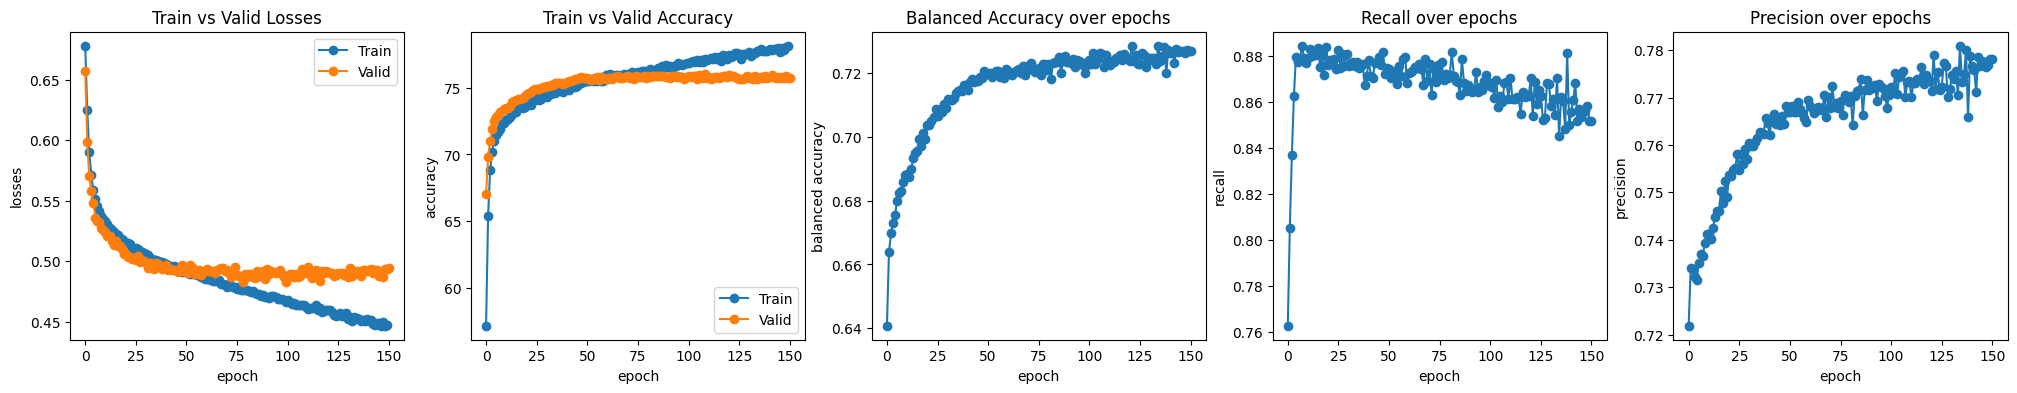

In [71]:
# plot the loss and accuracy and
metrics = {
    'train_losses': train_losses,
    'train_accu': train_accu,
    'eval_losses': eval_losses,
    'eval_accu': eval_accu,
    'balance_accuracy_list': balance_accuracy_list,
    'precision_list': precision_list,
    'recall_list': recall_list
}
plot_metrics(metrics, ['loss', 'accuracy', 'balance_accuracy', 'recall', 'precision'])

In [72]:
accuracy, precision, recall, balance_accuracy = test_model('models/FeedForwardNet/saved_model.pth', 'RCAST')

In [73]:
print(f'Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | Balance Accuracy: {balance_accuracy:.3f}')

Accuracy: 0.757 | Precision: 0.778 | Recall: 0.852 | Balance Accuracy: 0.727
